# test BP methods on *test_image*

In [1]:
from bp import build_image_factor_graph, Loopy_BP, URW_BP

import numpy as np
import matplotlib.pyplot as plt

import pickle, os

In [2]:
with open('test_image.pkl', 'rb') as f:
    image = pickle.load(f, encoding="latin1").astype(int)

img_shape = image.shape

Text(0.5, 1.0, 'histogram of pixel intensities')

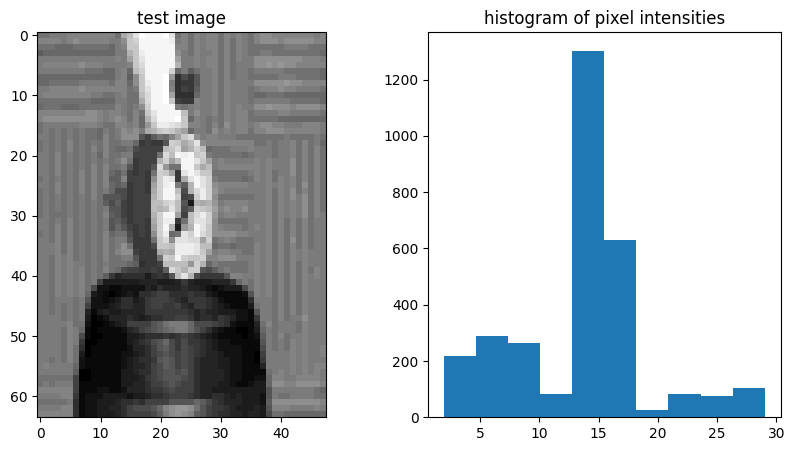

In [3]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image, cmap='gray')
ax0.set_title('test image')
ax1.hist(image.flatten())
ax1.set_title('histogram of pixel intensities')

In [4]:
NUM_PIXELS_INTENSITY = 32
low, high = 13, 17

distrib_int_obs = np.zeros((NUM_PIXELS_INTENSITY, 2)) + .1
distrib_int_obs[low:high, 1] = 1
distrib_int_obs[:low, 0] = 1
distrib_int_obs[high:, 0] = 1

distrib_clc_neigh = np.array([[1, .1], [.1, 1]])

In [5]:
graph = build_image_factor_graph(image, distrib_int_obs, distrib_clc_neigh)

In [6]:
# beliefs propagation using URW_BP
N = 50


model_URW = URW_BP(graph)
model_loopy = Loopy_BP(graph)

beliefs_evol_URW = [] # to keep track of the beliefs evolution on one of the classes
beliefs_evol_loopy = []

for i in range(N) :
    print(i, end='\r')

    model_URW.loop()
    beliefs = np.array([model_URW.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_URW.append(beliefs[:, 1].reshape(img_shape))

    model_loopy.loop()
    beliefs = np.array([model_loopy.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_loopy.append(beliefs[:, 1].reshape(img_shape))

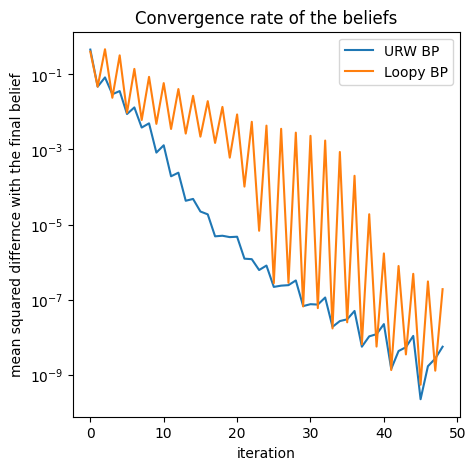

In [7]:
change_URW = np.zeros(N-1)
change_loopy = np.zeros(N-1)

for i in range(N-1):
    change_URW[i] = np.mean((beliefs_evol_URW[i] - beliefs_evol_URW[-1])**2)
    change_loopy[i] = np.mean((beliefs_evol_loopy[i] - beliefs_evol_loopy[-1])**2)

plt.figure(figsize=(5, 5))
plt.yscale('log')   
plt.title('Convergence rate of the beliefs')
plt.xlabel('iteration')
plt.ylabel('mean squared differnce with the final belief')
plt.plot(change_URW, label='URW BP')
plt.plot(change_loopy, label='Loopy BP')
plt.legend()
plt.show()

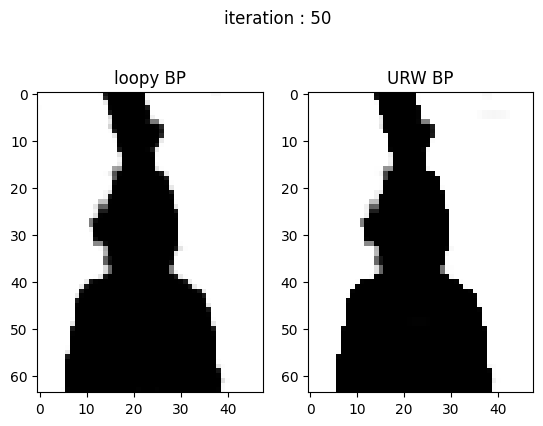

In [8]:
from matplotlib.animation import FuncAnimation


beliefs0 = beliefs_evol_loopy[0]
beliefs1 = beliefs_evol_URW[0]

# Create a figure and axis
fig, (ax0, ax1) = plt.subplots(1, 2)
suptitle = fig.suptitle('iteration : 1')
ax0.set_title('loopy BP')
ax1.set_title('URW BP')

# Initialize the imshow plot with the first frame of data
im0 = ax0.imshow(beliefs0, cmap='grey', vmin=0, vmax=1)
im1 = ax1.imshow(beliefs1, cmap='grey', vmin=0, vmax=1)

# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))
    im0.set_array(beliefs_evol_loopy[frame])  
    im1.set_array(beliefs_evol_URW[frame])
    return suptitle, im0, im1

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
save_to = os.path.join('res_test', 'comparaison_loopy_URW.gif')
ani.save(save_to, writer='pillow', fps=2)  # Adjust fps as needed
plt.show()

In [13]:
# fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

# ax0.set_yscale('log')   
# ax0.set_title('Convergence rate of the beliefs')
# ax0.set_xlabel('iteration')
# ax0.set_ylabel('mean squared differnce with the final belief')
# ax0.plot(change_URW, label='URW BP')
# ax0.plot(change_loopy, label='Loopy BP')
# ax0.legend()    

# ax1.set_title('loopy BP')
# ax1.imshow(beliefs_evol_loopy[-1], cmap='gray', vmin=0, vmax=1)

# ax2.set_title('URW BP')
# ax2.imshow(beliefs_evol_URW[-1], cmap='gray', vmin=0, vmax=1)

# plt.show()

## Comparaison of the rho parameter for the URW BP

In [11]:
rhos = np.linspace(0.1, 1, 10)
beliefs_evol_URW_rhos = []

for rho in rhos:
    print(rho, ':', end=' ')
    beliefs_URW_bp_temp = []

    model = URW_BP(graph, rho=rho)

    for i in range(N) :
        print(i, end='\r')

        model.loop()
        beliefs = np.array([model.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
        beliefs_URW_bp_temp.append(beliefs[:, 1].reshape(img_shape))    

    beliefs_evol_URW_rhos.append(beliefs_URW_bp_temp)
    print('done')


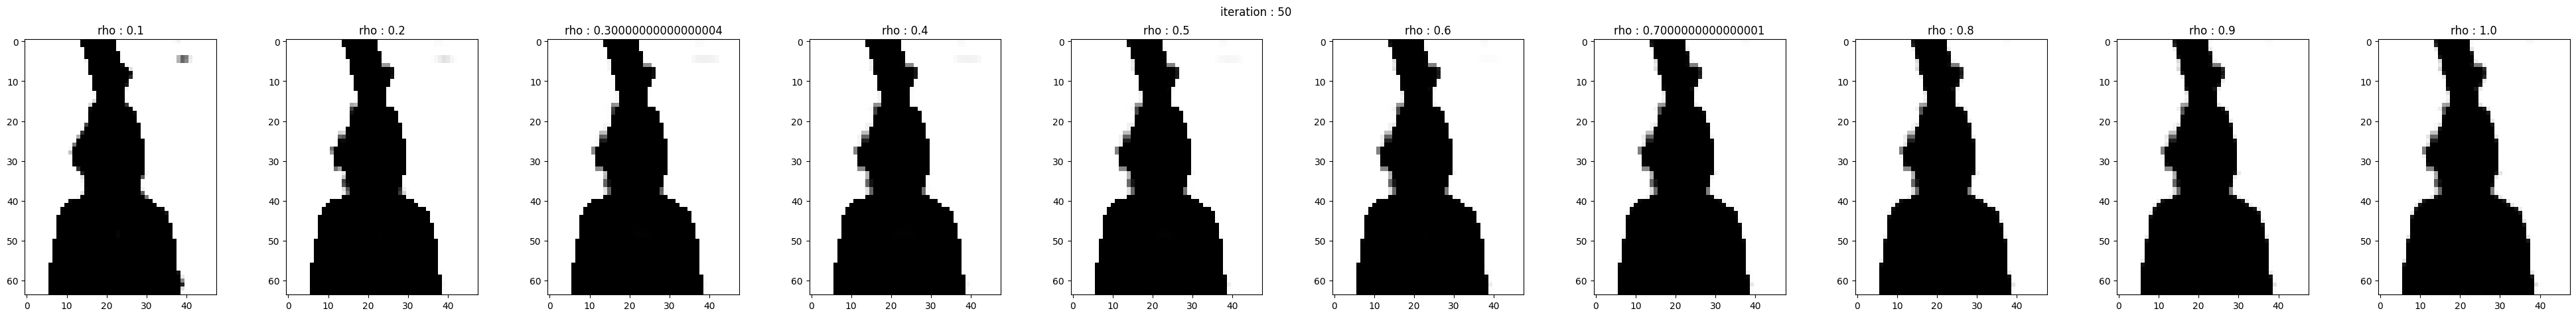

In [12]:
N_rho = len(rhos)


# Create a figure and axis
fig, axs = plt.subplots(1, N_rho, figsize=(5*N_rho, 5))
ims = []


suptitle = fig.suptitle('iteration : 1')
for i, ax in enumerate(axs):
    ax.set_title('rho : {}'.format(rhos[i]))
    im = ax.imshow(beliefs_evol_URW_rhos[i][0], cmap='grey', vmin=0, vmax=1)
    ims.append(im)


# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))

    for i, im in enumerate(ims):
        im.set_array(beliefs_evol_URW_rhos[i][frame])
    return suptitle, im0, im1

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
save_to = os.path.join('res_test', 'rho_comparaison.gif')
ani.save(save_to, writer='pillow', fps=2)  
plt.show()